# Creating dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [ ]:
DATADIR = '../datasets/Classification/Dataset - 3 dias/Images'
CATEGORIES = ["Normal", "Anormal", "Morta"]

In [ ]:
def create_training_data():
    training_data = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
            ## add images to training data with its label
            training_data.append([img_array, class_num])
    return training_data
            
training_data = create_training_data()
            

In [ ]:
print(len(training_data))

In [ ]:
#mix data for better learning
import random
random.shuffle(training_data)

In [ ]:
images = []
labels = []

for image, label in training_data:
    images.append(image)
    labels.append(label)

In [ ]:
##saving dataset
import pickle
DATASET_PATH = "../datasets/Classification/Dataset - 3 dias/"

pickle_out = open(os.path.join(DATASET_PATH, "3_days_images.pickle"), "wb")
pickle.dump(images, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(DATASET_PATH, "3_days_labels.pickle"), "wb")
pickle.dump(labels, pickle_out)
pickle_out.close()



# Creating classificatin model
##### Following this tutorial
       www.youtube.com/watch?v=WvoLTXIjBYU
##### Characteristics
 - Sequencial Model
 - Fully trained on this dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import keras
import os


#### Reading and preparing the dataset

In [ ]:
import imutils
def pad_image(image, size_x, size_y):
    shape = image.shape
    res = []
    
    pad_image = np.zeros((size_x,size_y,3), np.uint8)
    
    if shape[0] > shape[1]:
        res = imutils.resize(image, height=size_x)
        res = center_image(res, pad_image)
    else:
        res = imutils.resize(image, width=size_y)
        res = center_image(res, pad_image)
    
    return res
    
def center_image(image, background):
    img_shape = image.shape
    bck_shape = background.shape
    
    x_diff = round((bck_shape[0] - img_shape[0])/2)
    y_diff = round((bck_shape[1] - img_shape[1])/2)
    
#     print(image.shape, background.shape, x_diff, y_diff)
    
    res = background.copy()
    
    res[x_diff:x_diff + img_shape[0],y_diff:y_diff + img_shape[1]] = image
    
    return res
        

In [ ]:
images_raw = open(os.path.join(DATASET_PATH, "3_days_images.pickle" ), "rb")
images = pickle.load(images_raw)

labels_raw = open(os.path.join(DATASET_PATH, "3_days_labels.pickle" ), "rb")
labels = pickle.load(labels_raw)

#reshape images
IMG_SIZE = 256

##### Padding Images in Memory

In [ ]:
for i in range(len(images)):
    images[i] = pad_image(images[i], IMG_SIZE, IMG_SIZE)
    plt.imshow(images[i])

###### Train Test split

In [ ]:
images = np.array(images)

from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2)

In [ ]:
print(train_images.shape)

In [ ]:
# data augmentation with ImageDataGenerator -> did not go well
# from keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=False,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.25
# )
# datagen.fit(train_images)

# # it = datagen.flow(train_images, batch_size=1, save_to_dir="test", shuffle= True)

# # # generate samples and plot
# # for i in range(50):
# #      # generate batch of images
# #     batch = it.next()
# #     # convert to unsigned integers for viewing
# #     image = batch[0].astype('uint8')
# #     # plot raw pixel data
# #     plt.imshow(image, cmap="gray")
# #     plt.show()
# # show the figure


## Trying class weights
#it does not work withone hot encoded data
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(train_labels),
#                                                  train_labels)

from sklearn.utils import compute_sample_weight
sample_weights = compute_sample_weight('balanced', train_labels)

In [ ]:
print(train_labels[34])

##### Labels one hot enconding

In [ ]:
import pandas as pd

train_labels = pd.get_dummies(train_labels)
train_labels = pd.DataFrame.to_numpy(train_labels)

test_labels = pd.get_dummies(test_labels)
test_labels = pd.DataFrame.to_numpy(test_labels)


##### Normalizing training images

In [ ]:
# train_images = tf.keras.utils.normalize(train_images, axis=0, order=2)

#### Creating the model


In [18]:
EPOCHS = 30
TRAIN_TEST_SPLIT = 0.25
BATCH_SIZE = round( (1 - TRAIN_TEST_SPLIT) * train_images.shape[0] / 32)
print((1 - TRAIN_TEST_SPLIT) * train_images.shape[0],BATCH_SIZE)

660.0 21


In [19]:
model = Sequential()

model.add(   Conv2D(4, (3,3), input_shape=train_images.shape[1:])  )
model.add(Activation("relu"))
model.add(Dropout(0.2, input_shape=images.shape[1:]))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(2, (2,2)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(8))

model.add(Dense(3))
model.add(Activation("sigmoid"))


my_metrics = ["accuracy",
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.AUC(),
           tf.keras.metrics.TruePositives(),
           tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.FalsePositives(),
           tf.keras.metrics.FalseNegatives(),]

opt = keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=my_metrics)

In [20]:
history = model.fit(train_images, train_labels, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split=TRAIN_TEST_SPLIT, sample_weight=sample_weights)

Epoch 1/30
32/32 [==============================] - 6s 165ms/step - loss: 1.7087 - accuracy: 0.3920 - precision: 0.3483 - recall: 0.5125 - auc: 0.5249 - true_positives: 183.4848 - true_negatives: 371.7879 - false_positives: 339.4848 - false_negatives: 172.1515 - val_loss: 1.4028 - val_accuracy: 0.4318 - val_precision: 0.3706 - val_recall: 0.5727 - val_auc: 0.5669 - val_true_positives: 126.0000 - val_true_negatives: 226.0000 - val_false_positives: 214.0000 - val_false_negatives: 94.0000
Epoch 2/30
32/32 [==============================] - 4s 138ms/step - loss: 1.5778 - accuracy: 0.4827 - precision: 0.3878 - recall: 0.5280 - auc: 0.5814 - true_positives: 187.1212 - true_negatives: 417.4242 - false_positives: 293.8485 - false_negatives: 168.5152 - val_loss: 1.4399 - val_accuracy: 0.4409 - val_precision: 0.3790 - val_recall: 0.5409 - val_auc: 0.5780 - val_true_positives: 119.0000 - val_true_negatives: 245.0000 - val_false_positives: 195.0000 - val_false_negatives: 101.0000
Epoch 3/30
32/32 

Epoch 18/30
32/32 [==============================] - 5s 143ms/step - loss: 0.5710 - accuracy: 0.8432 - precision: 0.6822 - recall: 0.7307 - auc: 0.8516 - true_positives: 250.7879 - true_negatives: 589.5152 - false_positives: 121.7576 - false_negatives: 104.8485 - val_loss: 1.2174 - val_accuracy: 0.7909 - val_precision: 0.6864 - val_recall: 0.6864 - val_auc: 0.8529 - val_true_positives: 151.0000 - val_true_negatives: 371.0000 - val_false_positives: 69.0000 - val_false_negatives: 69.0000
Epoch 19/30
32/32 [==============================] - 5s 166ms/step - loss: 0.5295 - accuracy: 0.8496 - precision: 0.6829 - recall: 0.6990 - auc: 0.8578 - true_positives: 247.9697 - true_negatives: 597.3333 - false_positives: 113.9394 - false_negatives: 107.6667 - val_loss: 1.2417 - val_accuracy: 0.7773 - val_precision: 0.6818 - val_recall: 0.6818 - val_auc: 0.8528 - val_true_positives: 150.0000 - val_true_negatives: 370.0000 - val_false_positives: 70.0000 - val_false_negatives: 70.0000
Epoch 20/30
32/32 

In [21]:
model.evaluate(test_images, test_labels)

7/7 [==============================] - 1s 72ms/step - loss: 1.0533 - accuracy: 0.7330 - precision: 0.6008 - recall: 0.6742 - auc: 0.8051 - true_positives: 149.0000 - true_negatives: 343.0000 - false_positives: 99.0000 - false_negatives: 72.0000


[1.0533299446105957,
 0.733031690120697,
 0.600806474685669,
 0.6742081642150879,
 0.8051483631134033,
 149.0,
 343.0,
 99.0,
 72.0]

#### Visualizing model data

In [22]:
import matplotlib.pyplot as plt

In [27]:
NUM_METRICS = len(my_metrics)
METRICDIR = './metricas/classificacao/3_d/weighted/'
SAVE = True

def plot_metric(metric_name, chart_name):
    plt.plot(history.history[metric_name], label = metric_name + ' (training data)')
    plt.plot(history.history['val_' + metric_name], label = metric_name + ' (validation data)')
    plt.title(chart_name)
    plt.ylabel( metric_name + ' value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    if SAVE and not os.path.exists(METRICDIR):
        os.mkdir(METRICDIR)
    if SAVE:
        plt.savefig(os.path.join(METRICDIR, metric_name))
    plt.show()


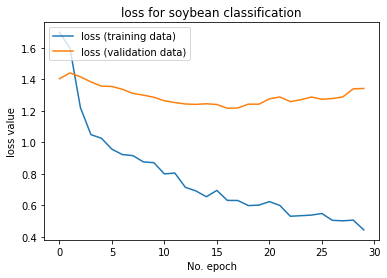

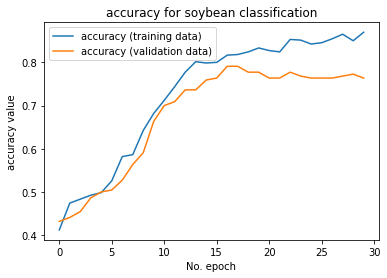

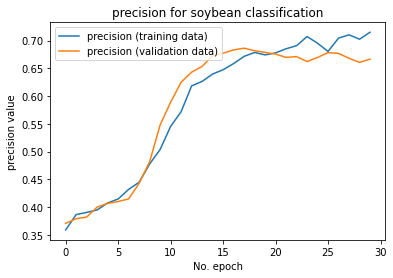

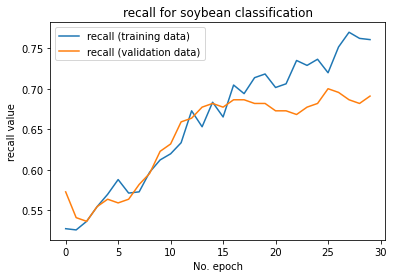

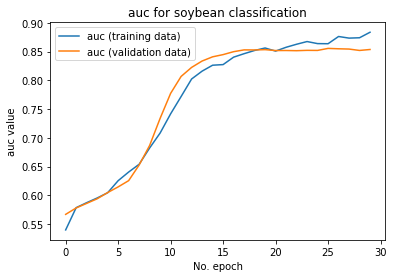

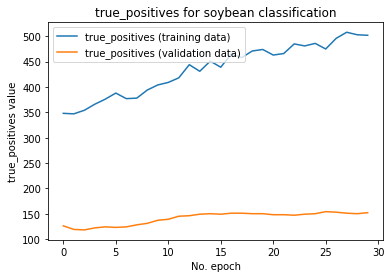

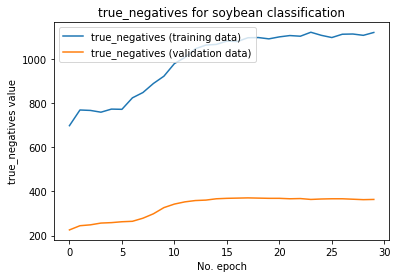

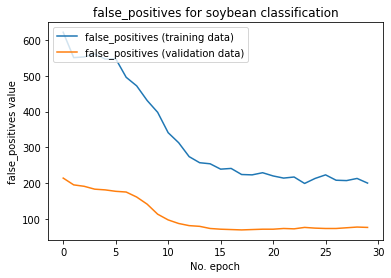

In [28]:
for metric in list(history.history.keys())[:NUM_METRICS]:
    plot_metric(metric, metric + " for soybean classification")


In [29]:
MODELDIR = os.path.join(METRICDIR, "model")
if SAVE and not os.path.exists(MODELDIR):
    os.mkdir(MODELDIR)
model.save(MODELDIR)

INFO:tensorflow:Assets written to: ./metricas/classificacao/3_d/weighted/model/assets
